# Classification Trees and Random Forest Classification (supermarket data)

In this notebook, we will use Classification Tree and Random Forest classifiers to predict supermarket brands based on various features like location, population density, brand, and more. We will evaluate the models using feature importance, confusion matrices, and ROC curves.

## Libraries and settings

In [2]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/python_machine_learning_basics/Mauricio


In [3]:
# Herausfinden welche Spalten vorhancen sind 

# Laden Sie den Datensatz
df = pd.read_csv("./Data/student_grades_data.csv", sep=",", encoding='utf-8')

# Anzeigen der Spaltennamen
print(df.columns)

Index(['Student_ID', 'Branch', 'Grade', 'Study_Hours', 'IQ', 'Age', 'Weight',
       'Parents_Income'],
      dtype='object')


## Import supermarkets data

In [4]:
# Read and select variables
columns = ['Student_ID', 
           'Branch', 
           'Grade', 
           'Study_Hours', 
           'IQ', 
           'Age', 
           'Weight',
           'Parents_Income',
          ]
df_supermarkets_orig = pd.read_csv("./Data/student_grades_data.csv", 
                                   sep=",", 
                                   encoding="utf-8")[columns]

# Number of rows and columns
print(df_supermarkets_orig.shape)

# Brand to upper case letters
df_supermarkets_orig['Student_ID'] = df_supermarkets_orig['Student_ID'].str.upper()

# First records
df_supermarkets_orig.head(5)

(10000, 8)


,Student_ID,Branch,Grade,Study_Hours,IQ,Age,Weight,Parents_Income
0,STUDENT_0001,History,F,54,132,19,68,50043
1,STUDENT_0002,History,D,24,139,24,52,38024
2,STUDENT_0003,Engineering,C,35,158,25,86,33798
3,STUDENT_0004,Mathematics,F,35,104,20,85,118113
4,STUDENT_0005,Biology,C,57,154,24,82,54247


## Count and remove missing values

In [5]:
# Count missing values
print(df_supermarkets_orig.isna().sum())

# Remove missing values
df_supermarkets = df_supermarkets_orig.dropna()
df_supermarkets

Student_ID        0
Branch            0
Grade             0
Study_Hours       0
IQ                0
Age               0
Weight            0
Parents_Income    0
dtype: int64


,Student_ID,Branch,Grade,Study_Hours,IQ,Age,Weight,Parents_Income
0,STUDENT_0001,History,F,54,132,19,68,50043
1,STUDENT_0002,History,D,24,139,24,52,38024
2,STUDENT_0003,Engineering,C,35,158,25,86,33798
3,STUDENT_0004,Mathematics,F,35,104,20,85,118113
4,STUDENT_0005,Biology,C,57,154,24,82,54247
...,...,...,...,...,...,...,...,...
9995,STUDENT_9996,Mathematics,A,31,133,22,84,137234
9996,STUDENT_9997,Mathematics,E,44,127,24,66,137616
9997,STUDENT_9998,Biology,C,34,137,20,66,141477
9998,STUDENT_9999,Mathematics,A,49,151,25,69,120200


## Subset with selected brands

In [6]:
df_sub = df_supermarkets.loc[df_supermarkets['Branch'].isin(['Mathematics', 'Biology'])]
print(df_sub.shape)
df_sub.head()

(4005, 8)


,Student_ID,Branch,Grade,Study_Hours,IQ,Age,Weight,Parents_Income
3,STUDENT_0004,Mathematics,F,35,104,20,85,118113
4,STUDENT_0005,Biology,C,57,154,24,82,54247
5,STUDENT_0006,Biology,A,32,91,25,50,81447
6,STUDENT_0007,Biology,B,20,131,24,71,105561
8,STUDENT_0009,Biology,A,55,121,22,52,112086


## Pivot table

In [7]:
# Berechnung des arith. Mittelwerts aller Werte (Summe aller Werte / Anzahl der Werte)
# lat = Breitengrad, lon = Längengrad, pop = Bevölkerung, pop_dens = Bevölkerungsdichte, 
# frg_pct = Ausländeranteil, emp = Beschäftigte

# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df_sub[['Student_ID', 
                       'Branch', 
                       'Grade', 
                       'Study_Hours', 
                       'IQ', 
                       'Age',
                       'Weight',
                       'Parents_Income']],
                index=['Branch'],
                values=[
                       'Study_Hours', 
                       'IQ', 
                       'Age',
                       'Weight',
                       'Parents_Income'],
                aggfunc=(np.mean, 'count')).round(0)

Age          IQ        Parents_Income          Study_Hours  \
            count  mean count   mean          count     mean       count   
Branch                                                                     
Biology      2017  21.0  2017  120.0           2017  84448.0        2017   
Mathematics  1988  22.0  1988  119.0           1988  86436.0        1988   

                  Weight        
             mean  count  mean  
Branch                          
Biology      30.0   2017  75.0  
Mathematics  30.0   1988  75.0

## Classification Tree
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [8]:
# Aufteilung in 2 Teile: nabhängigen Variablen (Features) und die abhängige Variable (Zielvariable)
# unabhänige Variablen: lat, lon, pop, pop_dens, frg_pct, emp
# train_test_split & test_size: Aufteilung in 80% Trainings- und 20% Testdaten
# random_state: Zufallszahlengenerator 42 reproduzierbar

# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_sub[['Study_Hours', 
                       'IQ', 
                       'Age',
                       'Weight',
                       'Parents_Income']],
                                                    df_sub['Branch'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      Study_Hours   IQ  Age  Weight  Parents_Income
5310           17   85   25      61           56015
6029           44  121   20      72          134109
4270           52   89   21      58           74512
1033           14   89   21      58          105444
7342           11  129   25      92           81922 

y_train:
5310    Mathematics
6029        Biology
4270    Mathematics
1033    Mathematics
7342        Biology
Name: Branch, dtype: object


### Fit the classification tree model and make predictions

In [9]:
# Initiliaizerung des Klassifikationsbaummodells mit clf = DecisionTreeClassifier
# Übergabe der Parameter random_state = 42 (reproduzierbar) und max_depth = 5 (Tiefe des Baumes)
# Trainieren des Klassifikationsbaummodells mit clf.fit(X_train, y_train)
# Vorhersage des Modells mit clf.predict(X_test)
# y_pred: Vorhersage des Modells (gespeichert als Variable)

# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=42, 
                             max_depth=5)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array(['Biology', 'Mathematics', 'Biology', 'Mathematics', 'Biology',
       'Mathematics', 'Mathematics', 'Mathematics', 'Biology',
       'Mathematics', 'Biology', 'Biology', 'Mathematics', 'Biology',
       'Mathematics', 'Mathematics', 'Biology', 'Biology', 'Biology',
       'Mathematics', 'Mathematics', 'Biology', 'Mathematics', 'Biology',
       'Biology', 'Mathematics', 'Biology', 'Biology', 'Biology',
       'Biology', 'Mathematics', 'Mathematics', 'Mathematics', 'Biology',
       'Mathematics', 'Biology', 'Biology', 'Mathematics', 'Mathematics',
       'Mathematics', 'Mathematics', 'Mathematics', 'Mathematics',
       'Mathematics', 'Mathematics', 'Biology', 'Mathematics', 'Biology',
       'Mathematics', 'Mathematics', 'Biology', 'Biology', 'Biology',
       'Biology', 'Mathematics', 'Mathematics', 'Mathematics',
       'Mathematics', 'Biology', 'Biology', 'Biology', 'Biology',
       'Biology', 'Biology', 'Mathematics', 'Mathematics', 'Mathematics',
       'Mathematics', 'Ma

### Show confusion matrix and classification report

In [ ]:
# Vergleich der Testdaten mit den Vorhersagen des Modells
# Confusion Matrix: 4x4 Matrix mit den Werten True Positive, True Negative, False Positive und False Negative

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Precision: Anteil der korrekt positiven Vorhersagen an allen positiven Vorhersagen
# Recall: Anteil der korrekt positiven Vorhersagen an allen tatsächlich positiven Werten
# F1-Score: Mittelwert aus Precision und Recall
# Support: Anzahl der tatsächlichen Werte

# Wert von 0.51 deutet auf schlechte Vorhersagequalität hin

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[216 201]
 [191 193]] 

Classification report
              precision    recall  f1-score   support

     Biology       0.53      0.52      0.52       417
 Mathematics       0.49      0.50      0.50       384

    accuracy                           0.51       801
   macro avg       0.51      0.51      0.51       801
weighted avg       0.51      0.51      0.51       801



### Print text representation of the classification tree

In [11]:
# Visualisierung des Klassifikationsbaums mit clf = DecisionTreeClassifier, 
# zuvor tree.export_text für Export in textuelle Form

# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- IQ <= 158.50
|   |--- Parents_Income <= 92294.50
|   |   |--- IQ <= 88.50
|   |   |   |--- Weight <= 75.50
|   |   |   |   |--- Weight <= 61.50
|   |   |   |   |   |--- class: Mathematics
|   |   |   |   |--- Weight >  61.50
|   |   |   |   |   |--- class: Biology
|   |   |   |--- Weight >  75.50
|   |   |   |   |--- IQ <= 81.50
|   |   |   |   |   |--- class: Biology
|   |   |   |   |--- IQ >  81.50
|   |   |   |   |   |--- class: Mathematics
|   |   |--- IQ >  88.50
|   |   |   |--- Weight <= 50.50
|   |   |   |   |--- Parents_Income <= 27120.00
|   |   |   |   |   |--- class: Biology
|   |   |   |   |--- Parents_Income >  27120.00
|   |   |   |   |   |--- class: Mathematics
|   |   |   |--- Weight >  50.50
|   |   |   |   |--- Parents_Income <= 90248.00
|   |   |   |   |   |--- class: Biology
|   |   |   |   |--- Parents_Income >  90248.00
|   |   |   |   |   |--- class: Biology
|   |--- Parents_Income >  92294.50
|   |   |--- Parents_Income <= 148838.50
|   |   |   |--- Parent

## Visualize the classification tree

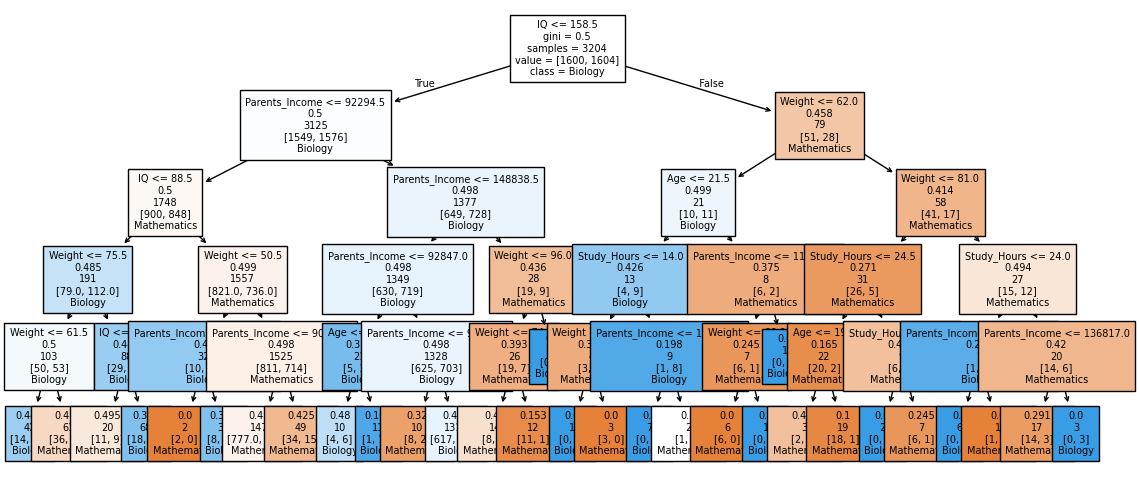

In [12]:
# feature_names=list(X_train.columns): Namen der unabhängigen Variablen
# class_names=['DENNER', 'COOP']: Namen der Zielvariablen
# filled=True: Füllung der Knoten, fontsize=7: Schriftgröße, label='root': Beschriftung des Wurzelknotens

# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(14,6))
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['Mathematics', 'Biology'],
                   filled=True,
                   fontsize=7,
                   label='root')

## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [14]:
# Aufteilung in 2 Teile: nabhängigen Variablen (Features) und die abhängige Variable (Zielvariable)
# unabhänige Variablen: lat, lon, pop, pop_dens, frg_pct, emp
# train_test_split & test_size: Aufteilung in 80% Trainings- und 20% Testdaten
# random_state: Zufallszahlengenerator 5 reproduzierbar

# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(df_sub[['Study_Hours', 
                       'IQ', 
                       'Age',
                       'Weight',
                       'Parents_Income']],
                                                        df_sub['Branch'], 
                                                        test_size=0.20, 
                                                        random_state=5)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
      Study_Hours   IQ  Age  Weight  Parents_Income
3672           58  134   22      74           31475
8656           16  127   25      57          141298
4164            0  141   22      97          146256
3723           36  158   25      99           44602
1211            1   98   24      91           82183 

y2_train:
3672    Mathematics
8656    Mathematics
4164        Biology
3723    Mathematics
1211        Biology
Name: Branch, dtype: object


### Fit the Random Forest Classifier

In [15]:
# n_estimators=500: Anzahl der Bäume im Wald, random_state=42: Zufallszahlengenerator reproduzierbar, max_depth=5: Tiefe des Baumes
# Trainieren des Random Forest Klassifikators mit rfc.fit(X2_train, y2_train)
# Vorhersage des Modells mit rfc.predict(X2_test)

# Initialize the random forest classifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5)

# Train the classification tree model
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable
y_pred_rf = rfc.predict(X2_test)

# Crosstab
print('Branch versus predicted Branch:', '\n')
df_pred = pd.DataFrame(data={'Branch': y2_test, 
                             'Branch_predicted': y_pred_rf}).reset_index(drop=True)
df_pred

Branch versus predicted Branch: 



,Branch,Branch_predicted
0,Mathematics,Biology
1,Mathematics,Biology
2,Mathematics,Biology
3,Biology,Mathematics
4,Mathematics,Mathematics
...,...,...
796,Biology,Biology
797,Mathematics,Biology
798,Mathematics,Mathematics
799,Biology,Mathematics


### Show confusion matrix and classification report

In [16]:
# Vergleich der Testdaten mit den Vorhersagen des Modells
# Confusion Matrix: 4x4 Matrix mit den Werten True Positive, True Negative, False Positive und False Negative

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Precision: Anteil der korrekt positiven Vorhersagen an allen positiven Vorhersagen
# Recall: Anteil der korrekt positiven Vorhersagen an allen tatsächlich positiven Werten
# F1-Score: Mittelwert aus Precision und Recall
# Support: Anzahl der tatsächlichen Werte

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))

Confusion matrix
[[183 240]
 [168 210]] 

Classification report
              precision    recall  f1-score   support

     Biology       0.52      0.43      0.47       423
 Mathematics       0.47      0.56      0.51       378

    accuracy                           0.49       801
   macro avg       0.49      0.49      0.49       801
weighted avg       0.50      0.49      0.49       801



### Show feature importance

Index(['Parents_Income', 'IQ', 'Study_Hours', 'Weight', 'Age'], dtype='object')
[0.32056461 0.20917839 0.19404717 0.19240634 0.08380349]


<Axes: ylabel='features'>

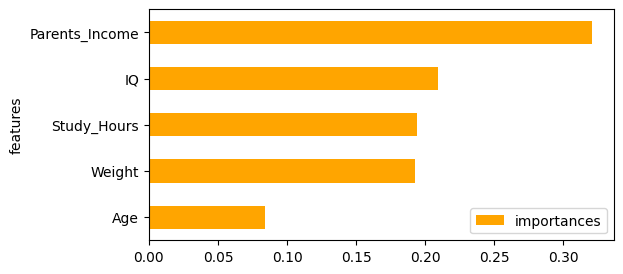

In [19]:
# Speichern der Spaltennamen aus X2_train in cols, LEDIGLICH Trainingsdaten anpassen??
cols = X2_train.columns

# Derive feature importance from the random forest classifier
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='orange', 
           figsize=(6,3))

### ROC curve and AUC

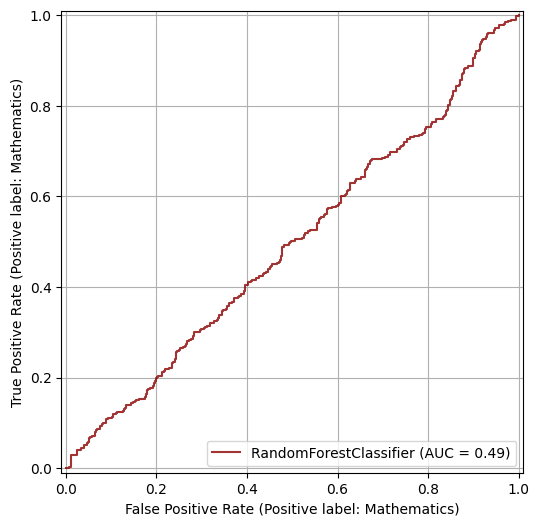

In [ ]:
# rfc: Random Forest Klassifikator, X2_test: Testdaten, y2_test: Zielvariable, 
# ax: Achse, alpha: Transparenz, c: Farbe, plt.grid(): Gitternetzlinien
# schlechte ROC Kurve, AUC-Wert von 0.5 linearer Verlauf

# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,6))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, 
                                          X2_test, 
                                          y2_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="darkred")
plt.grid()
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-11-10 10:27:47
Python Version: 3.11.10
-----------------------------------
